## Modelo generativo LDA y QDA para predecir si el cliente entrará en morosidad o no

### Importando las librerías necesarias

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

### Importando el dataset

> Importando datos de default_credit.csv

In [183]:
df = pd.read_csv('default_credit.csv')

### Observando el conjunto de datos

> Imprimimos las primeras y últimas 5 observaciones

> Observamos que hay 10000 observaciones, 4 atributos y un vector objetivo

> Vemos que debemos eliminar la columna index, ya que no aporta nada y los atributos default y student deberemos binarizarlas

In [184]:
df

,index,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879
...,...,...,...,...,...
9995,9996,No,No,711.555020,52992.378914
9996,9997,No,No,757.962918,19660.721768
9997,9998,No,No,845.411989,58636.156984
9998,9999,No,No,1569.009053,36669.112365


In [185]:
df.drop(columns = "index", inplace = True)

In [186]:
df

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


#### Pequeño resumen de los atributos:

1. **`default`:** Variable binaria. Registra si el cliente entró en morosidad o no
2. **`income`:** Ingreso promedio declarado por el cliente.
3. **`balance`:** Total del saldo en la cuenta de crédito.
4. **`student`:** Variable binaria, registra si el cliente es estudiante o no.


### Método describe() en el dataset

> El método describe() puede mostrar diferentes valores, como la cantidad, promedio, desviación estándard, valor mínimo, etc. de las variables numéricas

In [187]:
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


### Método info()

> Aplicamos este método para ver el tipo de dato y la cantidad de nulos de los atributos

> Observamos que no tenemos ningún dato nulo.

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [189]:
df["default"].unique()

array(['No', 'Yes'], dtype=object)

### Relaciones entre atributos y el vector objetivo

In [190]:
def get_pctje_morosos (df, var) :
    moroso = df[df[var] == "Yes"]
    not_moroso = df[df[var] == "No"]

    print ("Clientes morosos: %i (%.1f%%)"%(len(moroso), float(len(moroso))/len(df)*100.0))
    print ("Clientes no morosos: %i (%.1f%%)"%(len(not_moroso), float(len(not_moroso))/len(df)*100.0))
    print ("Total: %i"%len(df))

In [191]:
get_pctje_morosos (df, "default")

Clientes morosos: 333 (3.3%)
Clientes no morosos: 9667 (96.7%)
Total: 10000


### Student vs Default

In [192]:
df.student.value_counts()


No     7056
Yes    2944
Name: student, dtype: int64

default 
 No     9667
Yes     333
Name: default, dtype: int64 



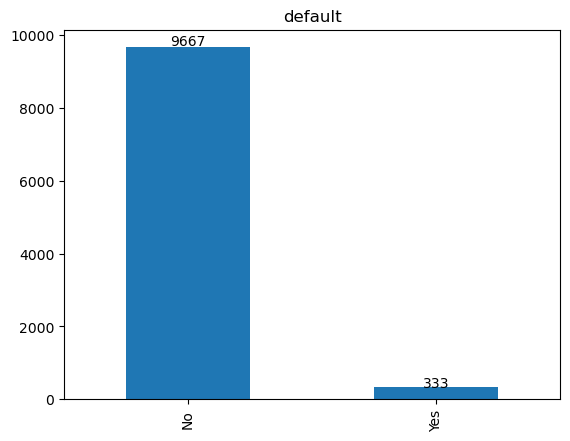

student 
 No     7056
Yes    2944
Name: student, dtype: int64 



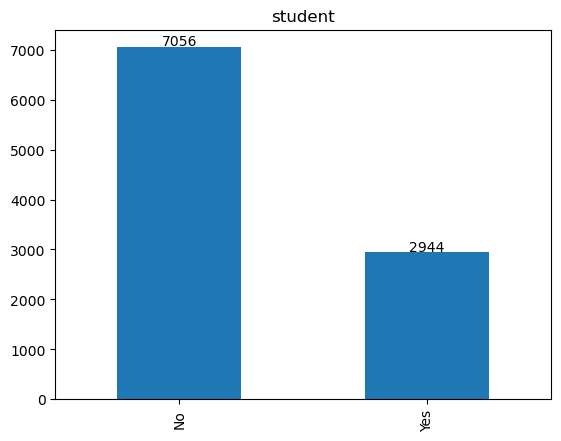

In [193]:
for i in df.select_dtypes(include='object').columns:
    print(i, '\n', df[i].value_counts(), '\n')
    vc = df[i].value_counts()
    ax = vc.plot(kind='bar')
    ax.set_title(i)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() * 1.005), ha = "center")
    plt.show()

- El 1er gráfico, indica la cantidad de clientes morosos, en este caso de esta base de datos, tenemos un total de 333 clientes morosos.
- El 2do gráfico indica si el cliente es estudiante o no, independiente de su morosidad, en este caso tenemos a casi 3000 estudiantes y a más de 7000 que no son estudiantes
- El 3er gráfico indica si el cliente es moroso o no, diferenciando si es estudiante o no

Text(0, 0.5, 'Cantidad de clientes')

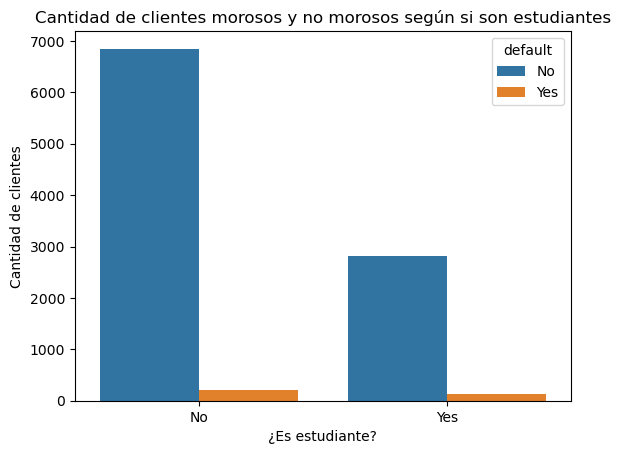

In [194]:
sns.countplot(x='student', hue='default', data=df)
plt.title('Cantidad de clientes morosos y no morosos según si son estudiantes')
plt.xlabel('¿Es estudiante?')
plt.ylabel('Cantidad de clientes')

### income vs default y balance vs default

In [195]:
variables_numericas = ["income", "balance"]

- Al visualizar los boxplots, se puede identificar rápidamente la presencia de valores atípicos en el atributo balance

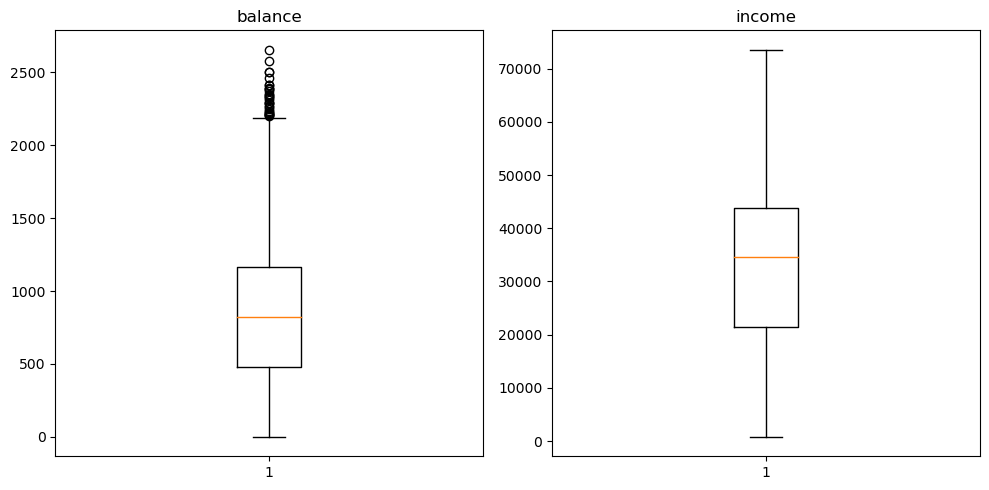

In [196]:
fig, axs = plt.subplots(nrows=1, ncols=len(df.select_dtypes(include='number').columns), figsize=(10, 5))

for i, col in enumerate(df.select_dtypes(include='number').columns):
    axs[i].boxplot(df[col].dropna())
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

- Los gráficos generados muestran la distribución de las variables "income" y "balance" en la base de datos de clientes morosos del banco.

- El primer gráfico muestra la distribución de ingresos de los clientes morosos. Podemos ver que la mayoría de los clientes tiene ingresos que se concentran en el rango de 0 a 50.000 dólares, con una pequeña cantidad de clientes que tienen ingresos más altos. La distribución es asimétrica hacia la derecha, lo que indica que hay pocos clientes con ingresos muy altos.

- El segundo gráfico muestra la distribución del saldo en las cuentas de crédito de los clientes morosos. Podemos observar que la mayoría de los clientes tiene un saldo bajo, pero hay un pequeño grupo de clientes con un saldo muy alto en su cuenta de crédito. La distribución de saldos es también asimétrica hacia la derecha, lo que sugiere que hay un número relativamente pequeño de clientes con saldos muy altos.

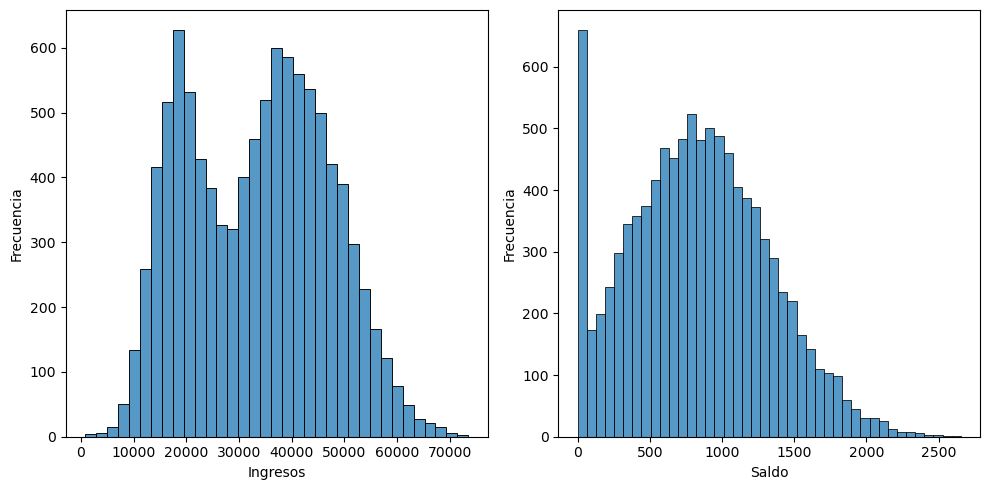

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(data=df, x="income", ax=axes[0])
axes[0].set_xlabel("Ingresos")
axes[0].set_ylabel("Frecuencia")

sns.histplot(data=df, x="balance", ax=axes[1])
axes[1].set_xlabel("Saldo")
axes[1].set_ylabel("Frecuencia")

plt.tight_layout()

#### Feature extraction

> Seleccionaremos los atributos adecuados para entrenar nuestros modelos

> Crearemos nuevos atributos basados en los ya existentes

> Convertiremos las variables categóricas en forma numérica

In [198]:
le = LabelEncoder()

df['default'] = le.fit_transform(df['default'])
df['student'] = le.fit_transform(df['student'])

In [199]:
df

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879
...,...,...,...,...
9995,0,0,711.555020,52992.378914
9996,0,0,757.962918,19660.721768
9997,0,0,845.411989,58636.156984
9998,0,0,1569.009053,36669.112365


## Modelación

> Generamos muestras de entrenamiento y validación

In [200]:
X = df.drop('default', axis=1)
y = df['default']

X_train_pre, X_test_pre, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

> Escalamos

In [201]:
scaler = StandardScaler().fit(X_train_pre)
X_train = pd.DataFrame (scaler.transform (X_train_pre), columns=X_train_pre.columns)
X_test = pd.DataFrame (scaler.transform (X_test_pre), columns=X_test_pre.columns)

> aplicamos LDA sin hiperparámetros

In [202]:

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

y_pred = lda.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3190
           1       0.79      0.25      0.38       110

    accuracy                           0.97      3300
   macro avg       0.88      0.62      0.68      3300
weighted avg       0.97      0.97      0.97      3300



- El modelo tiene un desempeño muy bueno en la predicción de la clase de no morosos, con todas sus métricas cercanas a 1
    - Esto indica que el modelo está siendo capaz de identificar correctamente la gran mayoría de los clientes no morosos
- Caso contrario sucede con la clase de morosos, sus métricas son bastante bajas
    - Esto indica que el modelo tiene dificultades para identificar a los clientes que entraron en morosidad
- En general, el modelo tiene una precisión promedio del 88%, pero hay un margen de mejora de los clientes morosos

- Dado que trabajamos con modelos generativos, podemos incluir información exógena. Para este caso agregaremos dos distribuciones:
    - Asumamos que hay un 50/50 de morosos y no morosos.
    - Asumamos que hay un 60/40 de morosos y no morosos.

> 50/50 de morosos y no morosos

In [203]:
lda_50_50 = LinearDiscriminantAnalysis(priors = [0.5, 0.5])
lda_50_50.fit(X_train, y_train)

y_pred_50_50 = lda_50_50.predict(X_test)

> 60/40 de morosos y no morosos

In [204]:

lda_60_40 = LinearDiscriminantAnalysis(priors = [0.6, 0.4])
lda_60_40.fit(X_train, y_train)

y_pred_60_40 = lda_60_40.predict(X_test)

In [205]:
print ("Métricas del modelo 50/50 \n")
print(classification_report(y_test, y_pred_50_50))

print ("Métricas del modelo 60/40 \n")
print(classification_report(y_test, y_pred_60_40))

Métricas del modelo 50/50 

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3190
           1       0.17      0.87      0.28       110

    accuracy                           0.85      3300
   macro avg       0.58      0.86      0.60      3300
weighted avg       0.97      0.85      0.89      3300

Métricas del modelo 60/40 

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3190
           1       0.21      0.85      0.33       110

    accuracy                           0.89      3300
   macro avg       0.60      0.87      0.63      3300
weighted avg       0.97      0.89      0.92      3300



> Volveremos a entrenar el modelo con los datos aumentados de forma artificial.

In [206]:
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=11238, sampling_strategy="minority")
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_resample(X_train,y_train)

In [207]:
lda_smote = LinearDiscriminantAnalysis()
lda_smote.fit(X_train_oversamp, y_train_oversamp)

y_pred_lda_smote = lda_smote.predict(X_test)


In [208]:
print ("Métricas del modelo oversampling \n")
print(classification_report(y_test, y_pred_lda_smote))

Métricas del modelo oversampling 

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3190
           1       0.17      0.87      0.28       110

    accuracy                           0.85      3300
   macro avg       0.58      0.86      0.60      3300
weighted avg       0.97      0.85      0.90      3300



- Vemos como el modelo mejora su capacidad para identificar correctamente a los clientes morosos aumentando el recall
- Sin embargo, la precisión y el f1 disminuye, lo que significa que el modelo clasifica erróneamente a más clientes como morosos
- En general SMOTE tienen un desempeño aceptable, pero no es perfecto y aún se puede mejorar

> Implementaremos un modelo QuadraticDiscriminantAnalysis con los datos aumentados artificialmente.

In [209]:

# Crear el modelo de QDA
qda = QuadraticDiscriminantAnalysis()

# Entrenar el modelo con los datos aumentados
qda.fit(X_train_oversamp, y_train_oversamp)

# Predecir los datos de validación
y_pred_qda_aug = qda.predict(X_test)

# Generar métricas de desempeño
print(classification_report(y_test, y_pred_qda_aug))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      3190
           1       0.18      0.85      0.30       110

    accuracy                           0.86      3300
   macro avg       0.59      0.86      0.61      3300
weighted avg       0.97      0.86      0.90      3300



- En general, el modelo que muestra un mejor desempeño es el modelo 1, que utiliza LinearDiscriminantAnalysis sin información exógena. Este modelo tiene la mayor precisión y f1-score para la clase minoritaria (1), lo que indica que es mejor para predecir la morosidad.

- Los otros modelos (modelo 2, 3 y 4) tienen un desempeño similar con precisión y f1-score bajos para la clase minoritaria, lo que indica que tienen dificultades para predecir la morosidad.

- El modelo 5, que utiliza QuadraticDiscriminantAnalysis, tiene un desempeño aún peor que los modelos anteriores en términos de precisión y f1-score para la clase minoritaria.

- Si nos enfocamos en la precisión, el mejor modelo para predecir a clientes morosos es el modelo 1

- Si nos enfocamos en el recall, el mejor modelo para predecir a clientes morosos es el modelo 2 o el 4